<h1> Link Partitioning by Partioning Around Medoids - Exact </h1>
<br/>
Distance function: Amplified Commute Distance

In [51]:
import numpy as np
import random
random.seed = 108
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
%matplotlib inline

In [52]:
!pwd

/home/latna/aponom/clustering/Scripts


In [53]:
!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar

Missing required options: i, k
usage: PMPClustering <-i input_file> <-k number_of_clusters> [-ftbcd]
 -a,--algorithm <arg>      Specifies algorithm that will be used to find
                           disjoint edge clusters. Possible values:
                           pmp (p-median exact algorithm).
                           kmd (k-medoids heuristic)
                           kmn (k-means heuristic).
                           If this option is omitted, the P-Median
                           algorithm will be used.
 -b,--benchmark            use benchmark format (.dat file)
 -d,--distance <arg>       the type of function to measure the distance
                           between nodes.
                           Possible values:
                           sp (shortest path)
                           gd (Generalize Degree)
                           cm (Commute Distance)
                           acm (Amplified Commute Distance).
                           If this option is omitted

In [72]:
def lp_experiment(clustersNumber, algorithm, distance, inputFile, groundTruth, params = {}, vertexNumerationShift=0, benchmarkFormat=False, verbose=False):
    datasetName = inputFile.split('/')[-2]
    sufix = inputFile.split('/')[-1].split('.')[0]
    outputDir = "../Results/lp_{}_{}_{}".format(algorithm, distance, datasetName)
    outputFile = outputDir +'/' +"pmp_{3}_{2}_{0}_{1}.dat".format(algorithm, clustersNumber, distance.upper(), sufix)
    print("Output dir name: {}".format(outputDir) )
    print("Output file name: {}".format(outputFile) )
    all_results = {}
    bestParam = "not found"
    nmi_best = 0;
    param_list = list(generate_params(params))
    tmp = None
    for param in tqdm(param_list):
        if benchmarkFormat:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} -gt {groundTruth} {param}
            tmpFile = outputFile
        else:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} -gt {groundTruth} {param}
            lines=[]
            with open(outputFile) as f:
                lines = f.readlines()    
            tmpFile="tmpFile.dat"
            with open(tmpFile, 'w') as the_file:
                for line in lines:
                    the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

        output=!../Overlapping-NMI/onmi {groundTruth} {tmpFile}
        nmi=float(output[0].split()[1])
        all_results[param] = nmi
        if nmi >  nmi_best:
            bestParam = param
            nmi_best = nmi
    #restorign solution for the best parameters 
    if benchmarkFormat:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} -gt {groundTruth} {bestParam}
        tmpFile = outputFile
    else:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} -gt {groundTruth} {bestParam}
        lines=[]
        with open(outputFile) as f:
            lines = f.readlines()    
        tmpFile="tmpFile.dat"
        with open(tmpFile, 'w') as the_file:
            for line in lines:
                the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

    if verbose:                                                                                                                                             
        print(tmp)
    print("Best ONMI: {} params: '{}'".format(nmi_best, bestParam) )
    return all_results

In [55]:
def generate_params(params):
    keys = list(params.keys())
    if len(keys) == 1:
        for value in params[keys[0]]:
            yield ( keys[0] + " " + str(value) )        
    if len( keys ) > 1:
        for value in params[keys[0]]:
            for remain_params in generate_params({k:params[k] for k in keys[1:]}):
                yield ( keys[0] + " " + str(value) + " " + remain_params )

In [56]:
def plot_all_params(algorithm, dataset, all_results ):
    xdata=[]
    ydata=[]
    df = pd.DataFrame()
    for param, nmi in all_results.items():
        splited = param.split()
        xdata.append(float(splited[1]))
        ydata.append(nmi)
        df = df.append({'x': float(splited[1]), 'y': nmi}, ignore_index=True)

    plt.plot(xdata, ydata, 'C3', zorder=1, lw=3)
    # ax = plt.axes(projection='3d')
    plt.scatter(xdata, ydata,s=70,zorder=2)
    plt.xlabel('threshold')
    plt.ylabel('nmi value');
    plt.title('Algorithm: {}\nDataset: {}'.format(algorithm, dataset));
    plt.show()

# School friendship network #

In [24]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)

In [58]:
all_results = lp_experiment(clustersNumber=7, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/school_friendship/school-2.gml", 
              groundTruth = "../datasets/school_friendship/truth-school.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False)

Output dir name: ../Results/lp_pmp_acm_school_friendship
Output file name: ../Results/lp_pmp_acm_school_friendship/pmp_school-2_ACM_pmp_7.dat



['Suffix: school-2', '# Nodes loaded: 70', '# Edges loaded: 194', 'Checking file /home/latna/aponom/clustering/Scripts/../Results/lp_pmp_acm_school_friendship/d_matrix_school-2_ACM_pmp_7.ser...found', 'Distance map between edges has been loaded. ', '', 'Checking file /home/latna/aponom/clustering/Scripts/../Results/lp_pmp_acm_school_friendship/d_matrix_school-2_ACM_pmp_7.ser...found', 'Distance map between edges has been loaded. ', '', 'Sorted clusters indices: [[7, 18, 54, 70, 100, 121, 163]]', 'PMP clusters: [{1={1=1, 6=2}, 2={1=6, 7=1}, 3={2=7}, 4={2=8}, 5={2=9}, 6={2=8, 7=3}, 7={2=5}, 8={2=8}, 9={2=2}, 10={2=4}, 11={2=2}, 12={2=8}, 13={3=2, 4=2}, 14={3=5}, 15={4=9}, 16={4=10}, 17={3=7}, 18={3=4}, 19={3=2, 4=2, 6=1}, 20={3=3}, 21={7=6}, 22={4=1, 7=3}, 23={2=1, 7=3}, 24={7=5}, 25={6=1, 7=5}, 26={7=5}, 27={5=9, 6=1}, 28={5=4}, 29={5=6}, 30={5=4}, 31={6=9}, 32={1=2, 3=1, 5=2, 6=3}, 33={1=1, 5=6}, 34={5=1, 6=8}, 35={5=1, 6=7}, 36={6=9}, 37={6=5}, 38={6=6}, 39={5=1, 6=3}, 40={6=4}, 41={

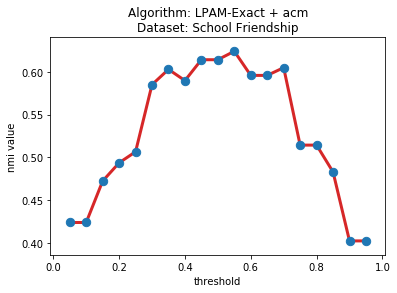

In [26]:
plot_all_params(algorithm = "LPAM-Exact + acm", dataset = "School Friendship", all_results = all_results)

## Clustering results for School Frienship Netwrok with the best parameters ##

![school-2_ACM_kmd_7_out](../final_pictures/school-2_ACM_pmp_7_out.png)

# Karate Club #

In [27]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/karate/karate.gml", 
              groundTruth = "../datasets/karate/truth_karate.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=False)

Output dir name: ../Results/lp_pmp_acm_karate
Output file name: ../Results/lp_pmp_acm_karate/pmp_karate_ACM_pmp_2.dat



Best ONMI: 0.91796 params: '-t 0.45'


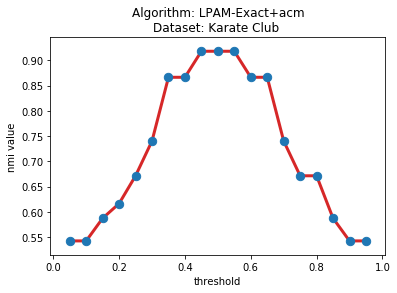

In [28]:
plot_all_params(algorithm = "LPAM-Exact+acm", dataset = "Karate Club ", all_results = all_results)

![karate_ACM_kmd_2_out](../final_pictures/karate_ACM_kmd_2_out.png)

# American Football League c = 12#

In [145]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=12, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/football/footballTSEinput.gml", 
              groundTruth = "../datasets/football/truth_footballTSEinput.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False)

Output dir name: lp_kmd_acm_football
Output file name: lp_kmd_acm_football/pmp_footballTSEinput_ACM_kmd_12.dat



Best ONMI: 0.856281 params: '-t 0.55'


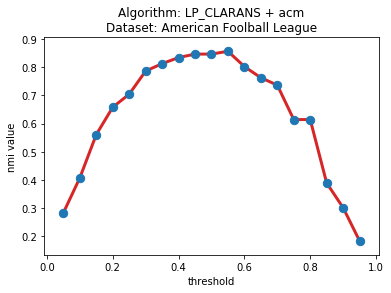

In [146]:
plot_all_params(algorithm = "LPAM-Heuristic-Clarance + acm", dataset = "American Foolball League", all_results = all_results)

### Americal Football League  [onmi: 0.856281; thresould: 0.55]

![American Football Club](../final_pictures/screenshot_235054.png)

# Adj-noun#

In [14]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile =  "../datasets/adjnoun/adjnoun.dat", 
              groundTruth = "../datasets/adjnoun/truth_adjnoun.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: lp_pmp_acm_adjnoun
Output file name: lp_pmp_acm_adjnoun/pmp_adjnoun_ACM_pmp_2.dat



Best ONMI: 0.00490969 params: '-t 0.1'


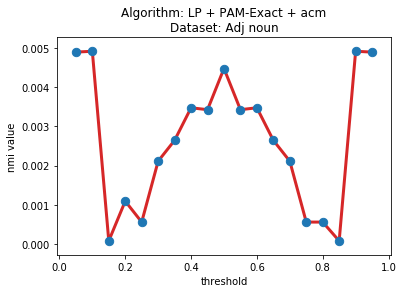

In [16]:
plot_all_params(algorithm = "LP + PAM-Exact + acm", dataset = "Adj noun", all_results = all_results)

### Adj-noun [ onmi: 0.00490969; thresould: 0.1 ] 

![adjnoun_ACM_kmd_2](../final_pictures/adjnoun_ACM_kmd_2_out.png)

# Politics Books #

In [100]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/polbooks/polbooks.dat",
              groundTruth = "../datasets/polbooks/truth_polbooks.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True, verbose=False)

Output dir name: ../Results/lp_pmp_acm_polbooks
Output file name: ../Results/lp_pmp_acm_polbooks/pmp_polbooks_ACM_pmp_2.dat



Best ONMI: 0.464154 params: '-t 0.55'


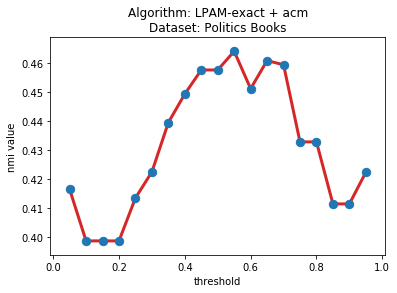

In [74]:
plot_all_params(algorithm = "LPAM-exact + acm", dataset = "Politics Books", all_results = all_results)

# Syntetic Datasets #

### bench_30 ###

In [98]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=3, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_30/bench_30_network.dat",
              groundTruth = "../datasets/bench_30/bench_30_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_bench_30
Output file name: ../Results/lp_pmp_acm_bench_30/pmp_bench_30_network_ACM_pmp_3.dat



Best ONMI: 0.931866 params: '-t 0.35000000000000003'


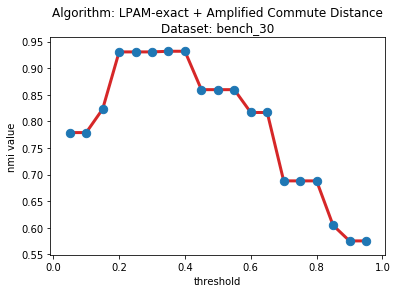

In [99]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_30", all_results = all_results)

![bench_30](../final_pictures/bench_30_network_ACM_pmp_3_out.png)

### bench_40 ###

In [80]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=4, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_40/bench_40_network.dat",
              groundTruth = "../datasets/bench_40/bench_40_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_bench_40
Output file name: ../Results/lp_pmp_acm_bench_40/pmp_bench_40_network_ACM_pmp_4.dat



Best ONMI: 0.346589 params: '-t 0.35000000000000003'


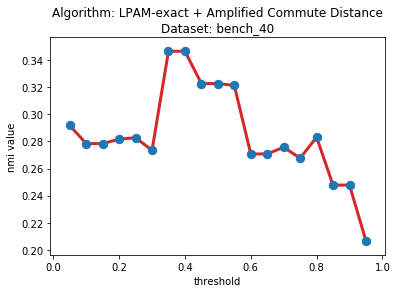

In [81]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_40", all_results = all_results)

![bench_50](../final_pictures/bench_40_network_ACM_pmp_4_out.png)

### bench_50 ###

In [75]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=4, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_50/bench_50_network.dat",
              groundTruth = "../datasets/bench_50/bench_50_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_bench_50
Output file name: ../Results/lp_pmp_acm_bench_50/pmp_bench_50_network_ACM_pmp_4.dat



Best ONMI: 0.845306 params: '-t 0.35000000000000003'


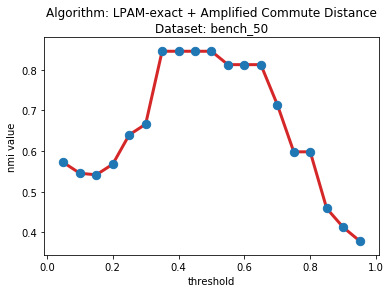

In [76]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_50", all_results = all_results)

![bench_50](../final_pictures/bench_50_network_ACM_pmp_4_out.png)

### bench_60 ###

In [85]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=6, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_60/bench_60_network.dat",
              groundTruth = "../datasets/bench_60/bench_60_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_bench_60
Output file name: ../Results/lp_pmp_acm_bench_60/pmp_bench_60_network_ACM_pmp_6.dat



Best ONMI: 0.60211 params: '-t 0.55'


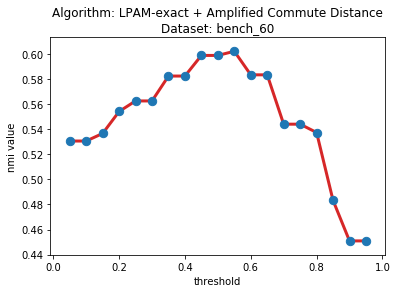

In [86]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_60", all_results = all_results)

![bench_60](../final_pictures/bench_60_network_ACM_pmp_6_out.png)

### bench_60 dense (mu = 0.25)###

In [96]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=6, 
              algorithm = "pmp",
              distance = "acm",
              inputFile = "../datasets/bench_60_dense/bench_60_dense_network.dat",
              groundTruth = "../datasets/bench_60_dense/bench_60_dense_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_pmp_acm_bench_60_dense
Output file name: ../Results/lp_pmp_acm_bench_60_dense/pmp_bench_60_dense_network_ACM_pmp_6.dat



Best ONMI: 0.466922 params: '-t 0.2'


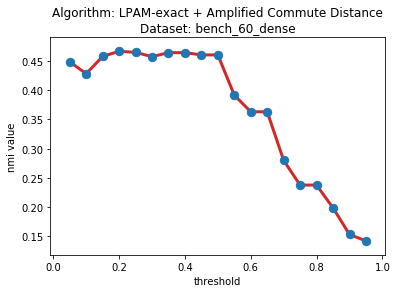

In [97]:
plot_all_params(algorithm = "LPAM-exact + Amplified Commute Distance", dataset = "bench_60_dense", all_results = all_results)

![bench_60](../final_pictures/bench_60_dense_network_ACM_pmp_6_out.png)